In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
import matplotlib.image as plt_image
from matplotlib.image import imread
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight

In [3]:
# from google.colab import drive

# drive.mount('/content/drive')

In [4]:
# import zipfile

# # Path ke file zip (ganti dengan path yang sesuai)
# zip_file_path = '/content/drive/MyDrive/OprekTA/dataset/aksaraJawabyPhiard.zip'

# # Path untuk mengekstrak file zip (ganti dengan path yang sesuai)
# data_path = '/content/aksara_jawa'

# # Mengekstrak file zip
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(data_path)

In [5]:
# Tentukan konstanta
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
NUM_CLASSES = 20
Class = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']
# train_dir = '/content/aksara_jawa/v3/v3/train'
# val_dir = '/content/aksara_jawa/v3/v3/val'

train_dir = "../data/databyPhiard_original/train" 
val_dir = "../data/databyPhiard_original/val"

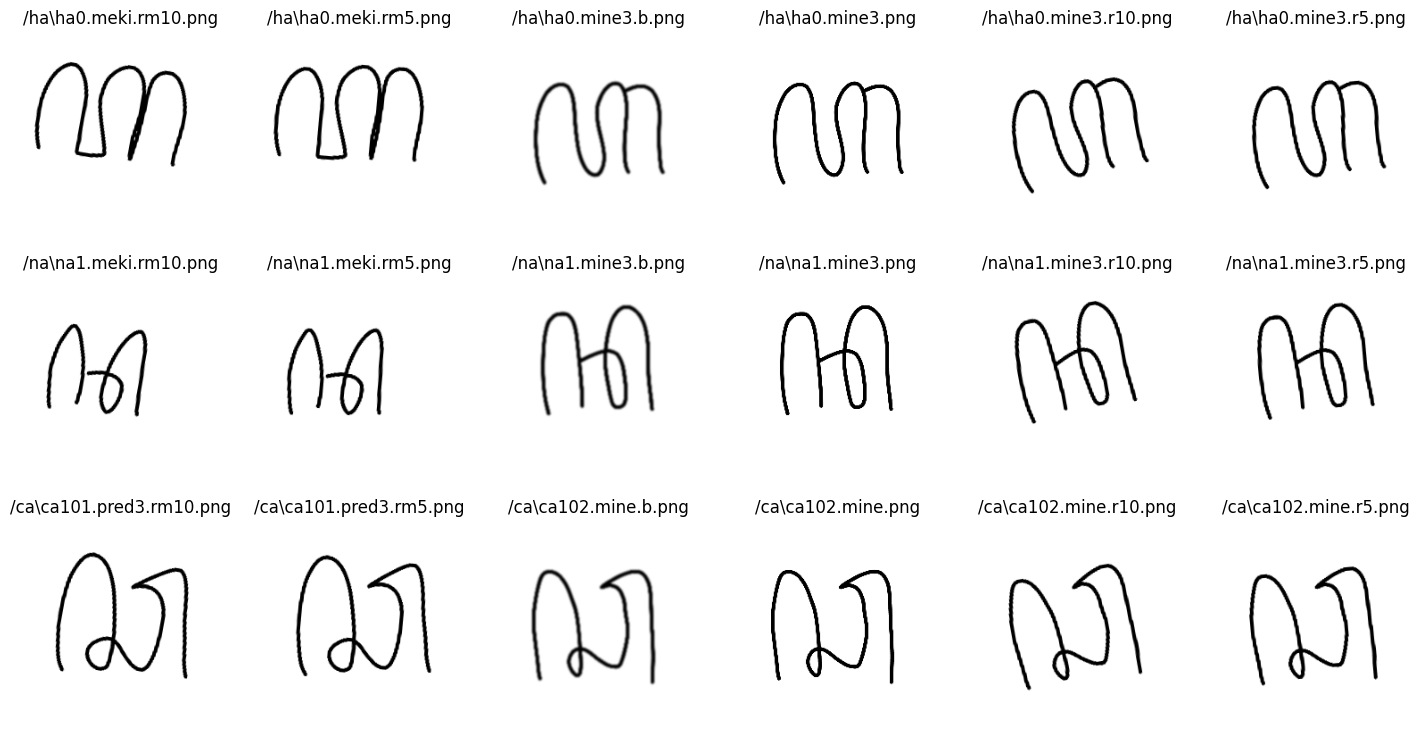

In [6]:
# Tentukan fungsi untuk menampilkan gambar
def show_random_images(directory, num_images=6):
    index = np.random.randint(20)  # Randomize the index
    plt.figure(figsize=(3*num_images, 9))

    # Buat daftar path gambar dari tiga kelas yang berbeda
    list_ha = [os.path.join('../data/databyPhiard_original/train/ha', name) for name in os.listdir(os.path.join(directory, 'ha'))[index:index+num_images]]
    list_na = [os.path.join('../data/databyPhiard_original/train/na', name) for name in os.listdir(os.path.join(directory, 'na'))[index:index+num_images]]
    list_ca = [os.path.join('../data/databyPhiard_original/train/ca', name) for name in os.listdir(os.path.join(directory, 'ca'))[index:index+num_images]]

    # Tampilkan gambar
    for i, path in enumerate(list_ha+list_na+list_ca):
        plt.subplot(3, num_images, i+1)
        plt.axis('off')
        plt.title(path.replace(os.path.join(train_dir), ''))
        img = plt_image.imread(path)
        plt.imshow(img)

# Panggil fungsi untuk menampilkan gambar setelah pelatihan model
show_random_images(train_dir, num_images=6)
plt.show()

In [8]:
def count_files(dir):
    arr = []
    for root, dirs, files in os.walk(dir):
        count = 0
        for name in files:
            if name.endswith(".png"):
              count = count + 1
        if count > 0:
          arr.append(count)
    return arr

def get_all_char_names(dir):
    arr = []
    for root, dirs, files in os.walk(dir):
        # print(dirs)
        arr.append(dirs)
        break
    return arr

20
[['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']]


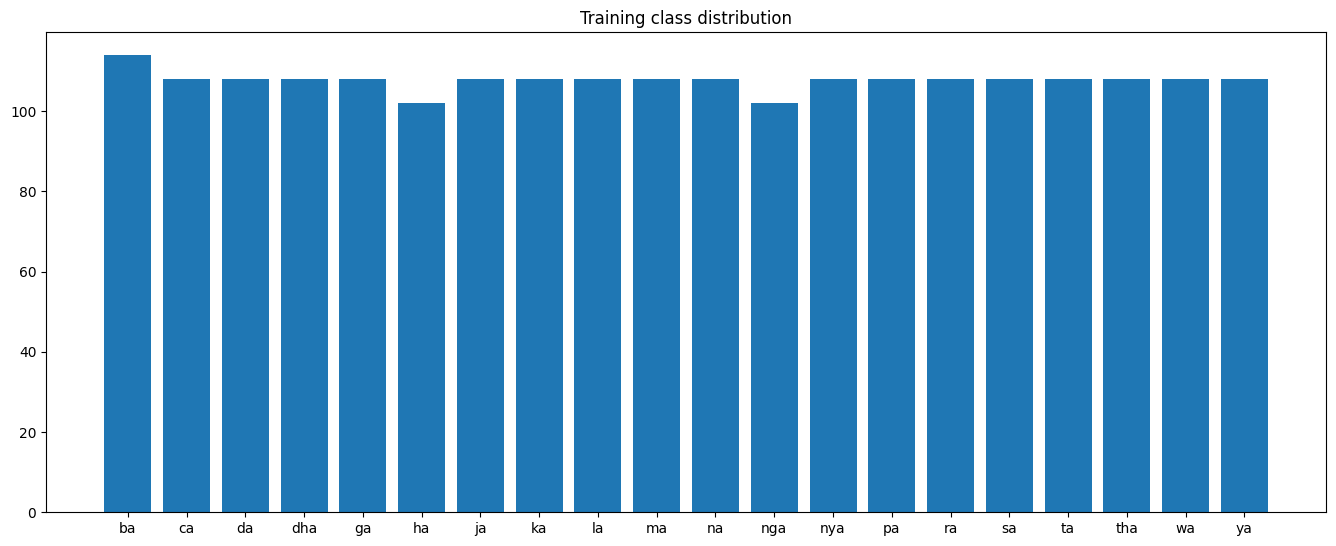

In [9]:
image_count = count_files(train_dir)
print(len(image_count))
chars = get_all_char_names(train_dir)
print(chars)

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(chars[0], image_count)
plt.title("Training class distribution")
plt.show()

In [10]:
# Menghitung jumlah gambar per kelas
file_list = os.listdir(train_dir)

jumlah_gambar_per_kelas = []

for kelas in file_list:
    kelas_path = os.path.join(train_dir, kelas)
    jumlah_gambar = len(os.listdir(kelas_path))
    jumlah_gambar_per_kelas.append(jumlah_gambar)

# Mengecek apakah jumlah data per kelas sudah seimbang
balanced = all(jumlah == jumlah_gambar_per_kelas[0] for jumlah in jumlah_gambar_per_kelas)

# Menampilkan pesan sesuai dengan hasil pemeriksaan
if balanced:
    print("Balanced Data !")
else:
    print("Imbalanced Data !!!\n")
    # Jika imbalanced, tampilkan jumlah data per kelas
    for kelas, jumlah in zip(file_list, jumlah_gambar_per_kelas):
        print(f'Aksara {kelas} jumlah: {jumlah}')

Imbalanced Data !!!

Aksara ba jumlah: 114
Aksara ca jumlah: 108
Aksara da jumlah: 108
Aksara dha jumlah: 108
Aksara ga jumlah: 108
Aksara ha jumlah: 102
Aksara ja jumlah: 108
Aksara ka jumlah: 108
Aksara la jumlah: 108
Aksara ma jumlah: 108
Aksara na jumlah: 108
Aksara nga jumlah: 102
Aksara nya jumlah: 108
Aksara pa jumlah: 108
Aksara ra jumlah: 108
Aksara sa jumlah: 108
Aksara ta jumlah: 108
Aksara tha jumlah: 108
Aksara wa jumlah: 108
Aksara ya jumlah: 108


20
[['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']]


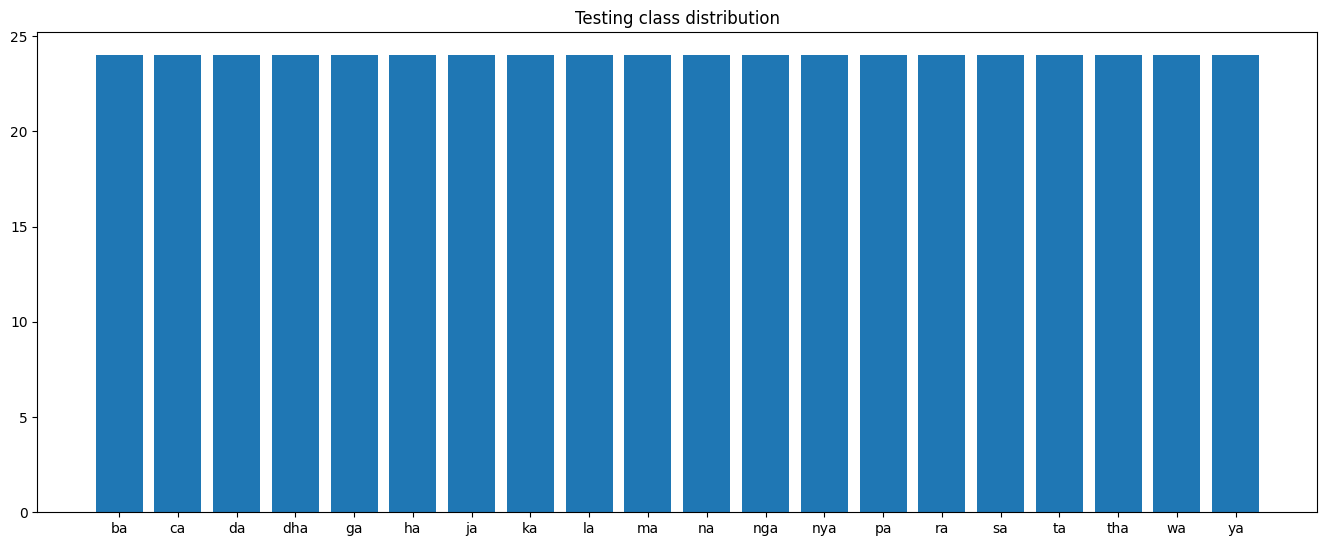

In [11]:
image_count = count_files(val_dir)
print(len(image_count))
chars = get_all_char_names(val_dir)
print(chars)

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(chars[0], image_count)
plt.title("Testing class distribution")
plt.show()

In [12]:
import random
import string
import shutil

# List kelas
kelas_aksara = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma',
                'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']

# Target jumlah gambar per kelas
target_jumlah = 114

# Loop untuk setiap kelas
for kelas in kelas_aksara:
    # Path kelas
    kelas_path = os.path.join(train_dir, kelas)

    # Jumlah gambar saat ini
    jumlah_gambar = len(os.listdir(kelas_path))

    # Selisih gambar yang perlu ditambahkan
    selisih = target_jumlah - jumlah_gambar

    # Jika selisih positif, lakukan oversampling
    if selisih > 0:
        # Ambil sampel acak dari gambar yang sudah ada
        gambar_oversampling = random.sample(os.listdir(kelas_path), selisih)

        # Copy gambar oversampling ke dalam kelas
        for gambar in gambar_oversampling:
            source_path = os.path.join(kelas_path, gambar)

            # Generate sufiks acak
            sufiks_acak = ''.join(random.choices(string.ascii_letters + string.digits, k=8))

            # Tentukan path tujuan dengan menambahkan sufiks acak
            target_path = os.path.join(kelas_path, f'{os.path.splitext(gambar)[0]}_{sufiks_acak}{os.path.splitext(gambar)[1]}')

            # Salin gambar ke target path
            shutil.copy(source_path, target_path)

In [13]:
# Fungsi untuk menghitung jumlah gambar per kelas
def count_images_per_class(folder_path):
    class_counts = {}
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)

        # Pastikan itu adalah direktori (bukan file)
        if os.path.isdir(class_path):
            # Hitung jumlah gambar dalam kelas
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_folder] = num_images
    return class_counts

# Hitung jumlah gambar per kelas sebelum augmentasi
original_counts = count_images_per_class(train_dir)
print("Jumlah gambar per kelas :")
print(original_counts)

Jumlah gambar per kelas :
{'ba': 114, 'ca': 114, 'da': 114, 'dha': 114, 'ga': 114, 'ha': 114, 'ja': 114, 'ka': 114, 'la': 114, 'ma': 114, 'na': 114, 'nga': 114, 'nya': 114, 'pa': 114, 'ra': 114, 'sa': 114, 'ta': 114, 'tha': 114, 'wa': 114, 'ya': 114}


In [14]:
# Buat generator data dengan augmentasi data untuk data pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

# Buat generator data tanpa augmentasi data untuk data validasi
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=Class
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=Class
)

Found 2280 images belonging to 20 classes.
Found 480 images belonging to 20 classes.


In [15]:
# Mencari class weights untuk mengatasi ketidakseimbangan kelas
class_weights = compute_sample_weight('balanced', train_generator.classes)
class_weight = dict(enumerate(class_weights))

In [16]:
# Create Architecture Vgg16
def create_vgg16_model(input_shape=(150, 150, 3), num_classes=NUM_CLASSES):
    model = Sequential()

    # Blok 1
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Blok 2
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Blok 3
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Blok 4
    model.add(Conv2D(filters=254, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=254, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=254, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Blok 5
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten(name='flatten'))

    # lapisan Dense 1
    # model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Dropout(0.75))

    # lapisan Dense 2
    # model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Dropout(0.75))

    model.add(Dense(num_classes, activation='softmax'))

    # Adam optimizer with learning rate scheduling and gradient clipping
    opt = Adam(learning_rate=0.0001, clipvalue=0.5)  # Gradient clipping
    # opt = Adam(learning_rate=1e-3, clipnorm=1.0)  # Gradient clipping
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Membuat model VGG16
model = create_vgg16_model()

# Menampilkan ringkasan model
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                      

In [17]:
# Fungsi untuk menetapkan learning rate secara dinamis
def lr_scheduler(epoch, lr):
    if epoch % 50 == 0 and epoch > 0:
        lr = lr * 0.9  # Contoh: Mengurangi learning rate setiap 10 epoch
    return lr

# Fungsi untuk menghentikan pelatihan jika akurasi mencapai 95%
# class AccuracyThreshold(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         if logs.get('accuracy') > 0.99:
#             print("\nAkurasi mencapai 95%! Menghentikan pelatihan.")
#             self.model.stop_training = True

# Menambahkan learning rate scheduler dan early stopping
lr_schedule = LearningRateScheduler(lr_scheduler)
# accuracy_threshold = AccuracyThreshold()
# callbacks_list = [lr_schedule, accuracy_threshold]
callbacks_list = [lr_schedule]

In [18]:
#melatih Model
a

Epoch 1/100


71/71 [==============================] - 2723s 37s/step - loss: 5.9952 - accuracy: 0.0537 - val_loss: 3.5602 - val_accuracy: 0.0500 - lr: 1.0000e-04
Epoch 2/100
71/71 [==============================] - 2046s 28s/step - loss: 5.6193 - accuracy: 0.0778 - val_loss: 4.0679 - val_accuracy: 0.0583 - lr: 1.0000e-04
Epoch 3/100
71/71 [==============================] - 2582s 36s/step - loss: 5.2299 - accuracy: 0.0876 - val_loss: 5.4204 - val_accuracy: 0.0542 - lr: 1.0000e-04
Epoch 4/100
71/71 [==============================] - 2142s 30s/step - loss: 5.0607 - accuracy: 0.0907 - val_loss: 7.3547 - val_accuracy: 0.0500 - lr: 1.0000e-04
Epoch 5/100
71/71 [==============================] - 1683s 24s/step - loss: 4.8052 - accuracy: 0.1161 - val_loss: 7.1656 - val_accuracy: 0.0500 - lr: 1.0000e-04
Epoch 6/100
71/71 [==============================] - 1216s 17s/step - loss: 4.6675 - accuracy: 0.1206 - val_loss: 4.0353 - val_accuracy: 0.0708 - lr: 1.0000e-04
Epoch 7/100
71/71 [=============

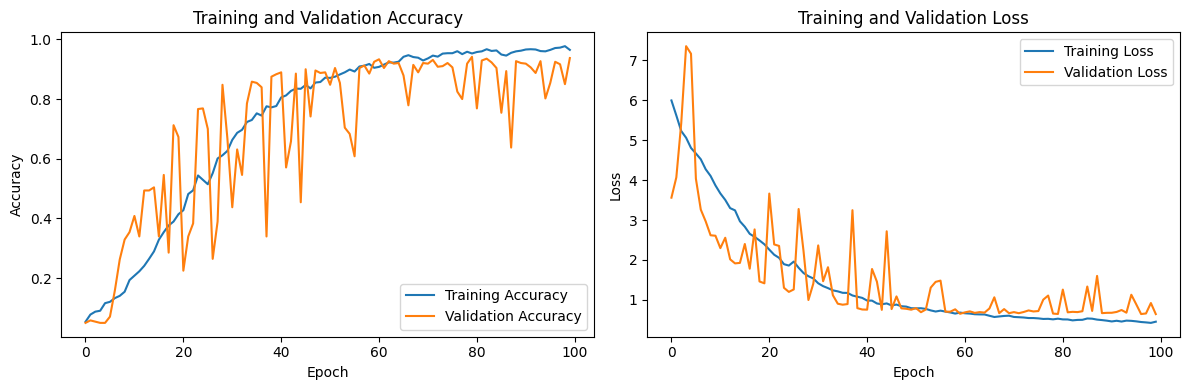

In [19]:
# Menampilkan grafik training dan validation accuracy
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [52]:
# Evaluasi model pada data uji
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

15/15 [==============================] - 98s 7s/step - loss: 0.6449 - accuracy: 0.9375
Test Accuracy: 93.75%


In [50]:
# Menyimpan Model
model.save('../models/aksarajawa_cnn_model.h5')

c:\Users\wawn1\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
# Import the necessary modules
from sklearn import metrics
import math

# Buat generator data untuk data uji
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    val_dir,
    shuffle=False,
    batch_size=32,
    color_mode="rgb",
    target_size=(150, 150),
    class_mode='categorical'
)

# Ganti np.math dengan math
test_steps_per_epoch = math.ceil(test_generator.samples / test_generator.batch_size)

# Gunakan Model.predict alih-alih Model.predict_generator
predictions = model.predict(test_generator, steps=test_steps_per_epoch)

# Dapatkan kelas yang paling mungkin
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

Found 480 images belonging to 20 classes.
15/15 [==============================] - 79s 5s/step


In [53]:
# Lakukan import untuk metrics
from sklearn import metrics

# Hitung dan tampilkan classification report
report = metrics.classification_report(true_classes,
                                       predicted_classes,
                                       target_names = class_labels)
print(report)

# Hitung dan tampilkan confusion matrix
confusion_matrix = metrics.confusion_matrix(true_classes, predicted_classes)
print(confusion_matrix)

              precision    recall  f1-score   support

          ba       1.00      1.00      1.00        24
          ca       0.92      1.00      0.96        24
          da       0.72      0.75      0.73        24
         dha       1.00      0.75      0.86        24
          ga       1.00      1.00      1.00        24
          ha       0.83      0.79      0.81        24
          ja       1.00      0.96      0.98        24
          ka       1.00      0.92      0.96        24
          la       1.00      0.96      0.98        24
          ma       1.00      1.00      1.00        24
          na       1.00      1.00      1.00        24
         nga       1.00      1.00      1.00        24
         nya       1.00      1.00      1.00        24
          pa       1.00      1.00      1.00        24
          ra       1.00      1.00      1.00        24
          sa       0.75      0.75      0.75        24
          ta       0.83      1.00      0.91        24
         tha       1.00    

<Axes: >

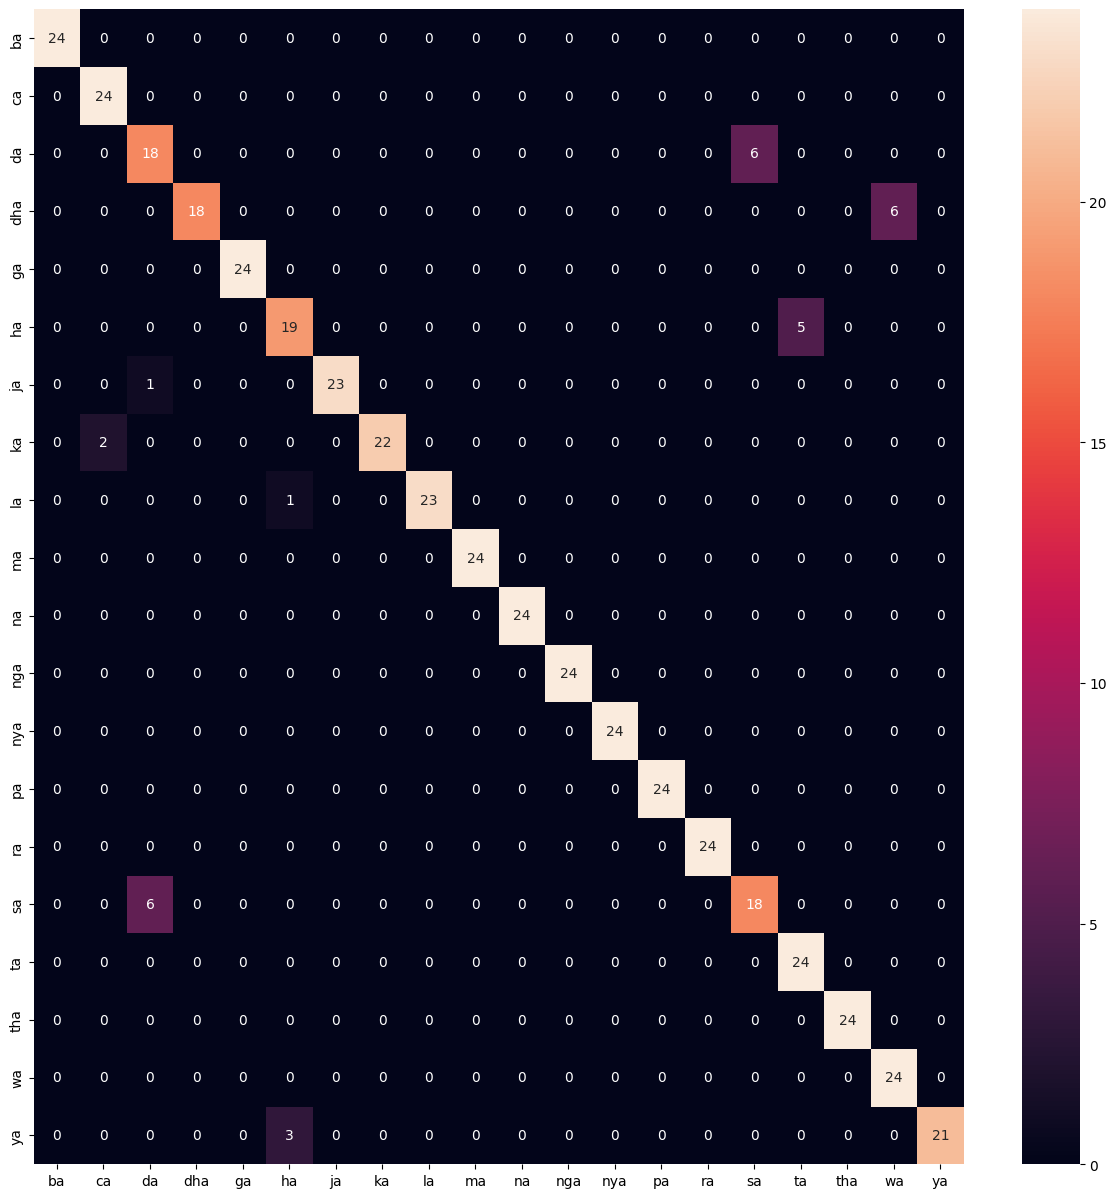

In [54]:
import pandas as pd
import seaborn as sn

# Buat DataFrame untuk confusion matrix
df_cm = pd.DataFrame(confusion_matrix,
                     index=[i for i in ("ba", "ca", "da", "dha", "ga", "ha", "ja", "ka", "la", "ma",
                                        "na", "nga", "nya", "pa", "ra", "sa", "ta", "tha", "wa", "ya")],

                     columns=[i for i in ("ba", "ca", "da", "dha", "ga", "ha", "ja", "ka", "la", "ma",
                                          "na", "nga", "nya", "pa", "ra", "sa", "ta", "tha", "wa", "ya")])
# Tampilkan heatmap
plt.figure(figsize=(15, 15))
sn.heatmap(df_cm, annot=True)

1/1 [==============================] - 2s 2s/step
Predicted class: ba


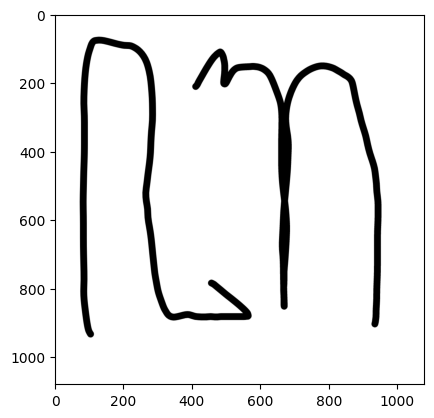

In [56]:
# Menguji Model
model = load_model('../models/aksarajawa_cnn_model.h5')
test_image_path = '../data/databyPhiard_original/prediction/ba17.png'
img = image.load_img(test_image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 158ms/step
Predicted class: ba


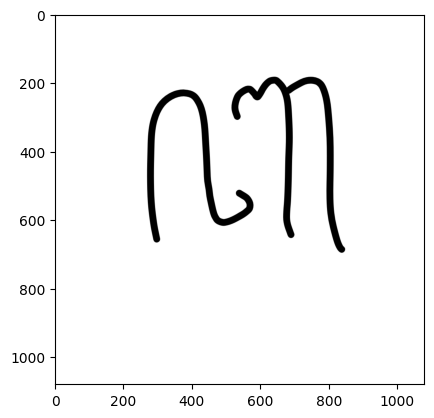

In [57]:
# Menguji Model
test_image_path2 = '../data/databyPhiard_original/prediction/ba49.mine2.png'
img = image.load_img(test_image_path2, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path2)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 148ms/step
Predicted class: ca


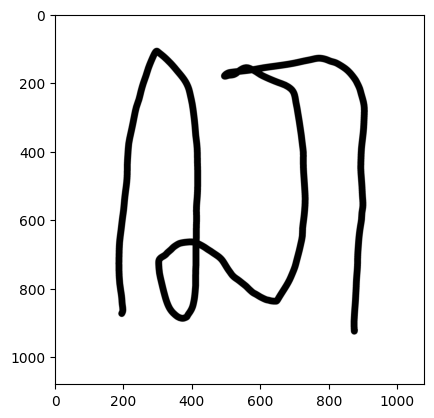

In [58]:
# Menguji Model
test_image_path3 = '../data/databyPhiard_original/prediction/ca2.png'
img = image.load_img(test_image_path3, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path3)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 271ms/step
Predicted class: da


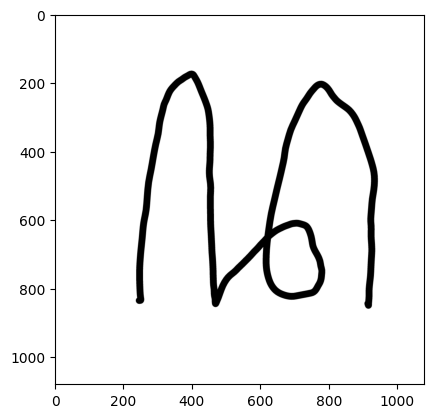

In [59]:
# Menguji Model
test_image_path4 = '../data/databyPhiard_original/prediction/da5.png'
img = image.load_img(test_image_path4, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path4)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 250ms/step
Predicted class: dha


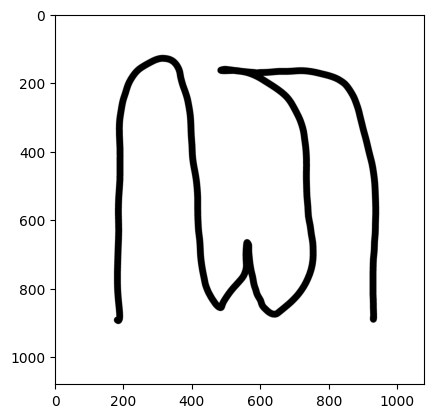

In [60]:
# Menguji Model
test_image_path5 = '../data/databyPhiard_original/prediction/dha11.png'
img = image.load_img(test_image_path5, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path5)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 170ms/step
Predicted class: ga


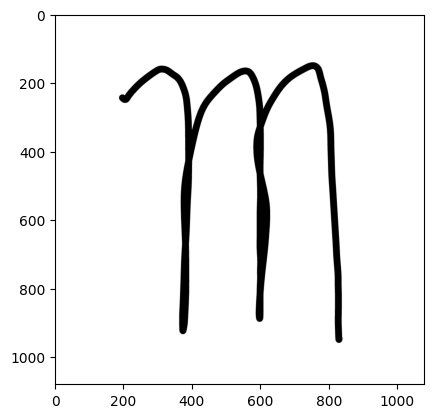

In [61]:
# Menguji Model
test_image_path6 = '../data/databyPhiard_original/prediction/ga16.png'
img = image.load_img(test_image_path6, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path6)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 144ms/step
Predicted class: la


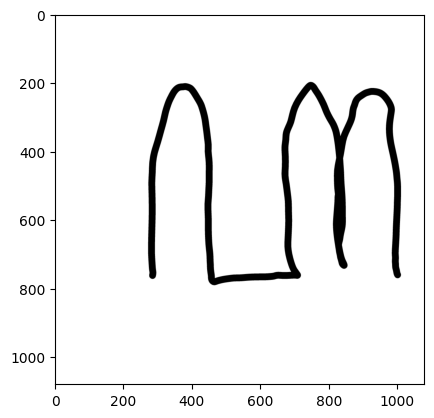

In [62]:
# Menguji Model
test_image_path7 = '../data/databyPhiard_original/prediction/ha0.png'
img = image.load_img(test_image_path7, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path7)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 163ms/step
Predicted class: ja


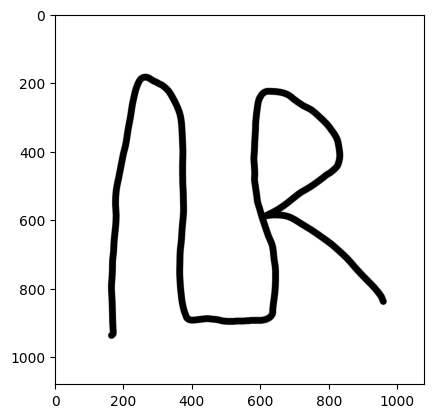

In [63]:
# Menguji Model
test_image_path8 = '../data/databyPhiard_original/prediction/ja12.png'
img = image.load_img(test_image_path8, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path8)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 269ms/step
Predicted class: ka


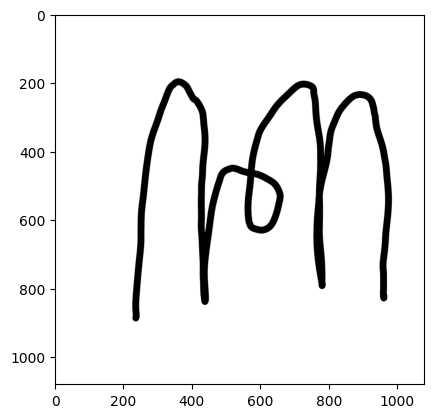

In [64]:
# Menguji Model
test_image_path9 = '../data/databyPhiard_original/prediction/ka4.png'
img = image.load_img(test_image_path9, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path9)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 292ms/step
Predicted class: la


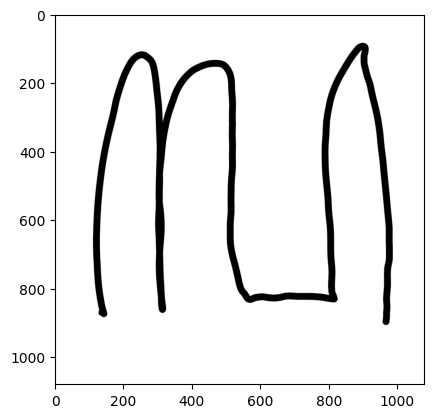

In [65]:
# Menguji Model
test_image_path10 = '../data/databyPhiard_original/prediction/la9.png'
img = image.load_img(test_image_path10, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path10)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 178ms/step
Predicted class: ra


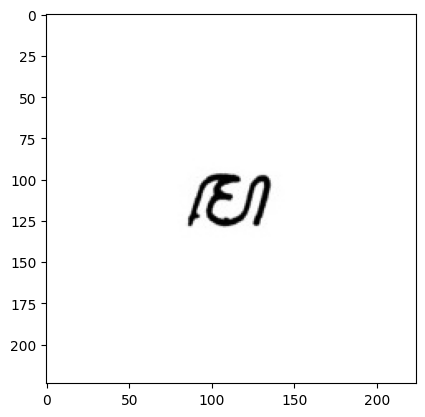

In [66]:
# Menguji Model
test_image_path11 = '../data/databyPhiard_original/prediction/ma.0.jpg'
img = image.load_img(test_image_path11, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path11)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 141ms/step
Predicted class: na


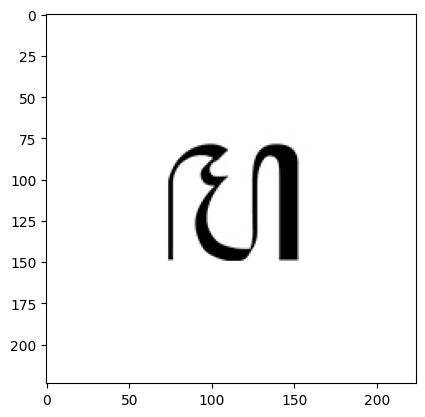

In [67]:
# Menguji Model
test_image_path12 = '../data/databyPhiard_original/prediction/ma.1.jpg'
img = image.load_img(test_image_path12, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path12)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 155ms/step
Predicted class: ma


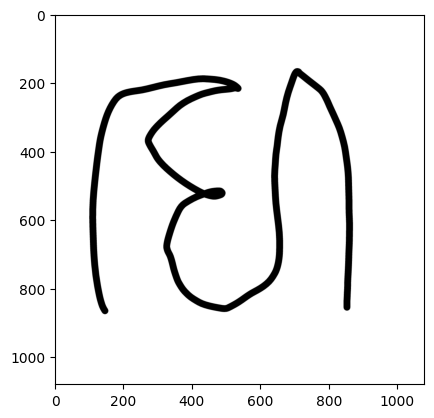

In [68]:
# Menguji Model
test_image_path13 = '../data/databyPhiard_original/prediction/ma15.png'
img = image.load_img(test_image_path13, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path13)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 149ms/step
Predicted class: na


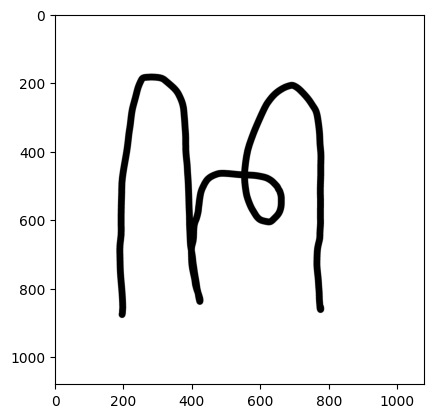

In [69]:
# Menguji Model
test_image_path14 = '../data/databyPhiard_original/prediction/na1.png'
img = image.load_img(test_image_path14, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path14)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 149ms/step
Predicted class: nga


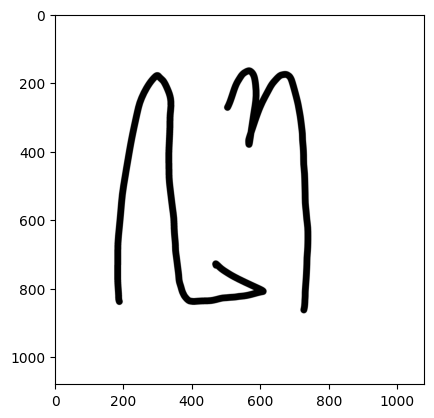

In [70]:
# Menguji Model
test_image_path15 = '../data/databyPhiard_original/prediction/nga19.png'
img = image.load_img(test_image_path15, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path15)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 254ms/step
Predicted class: nga


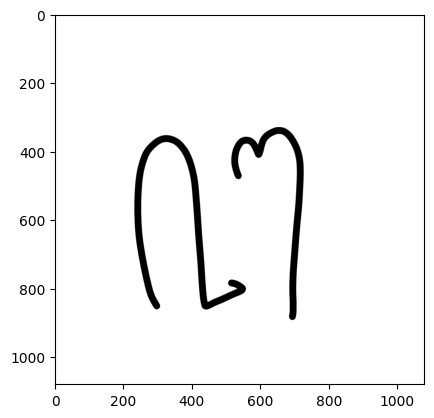

In [71]:
# Menguji Model
test_image_path16 = '../data/databyPhiard_original/prediction/nga220.pred.png'
img = image.load_img(test_image_path16, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path16)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 219ms/step
Predicted class: la


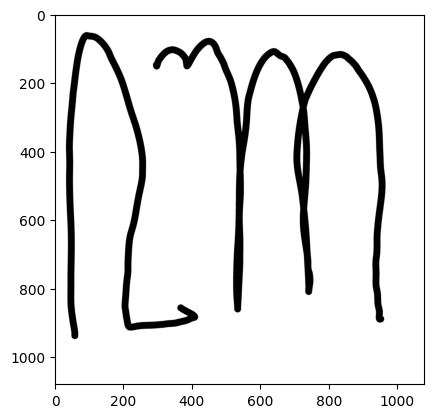

In [72]:
# Menguji Model
test_image_path17 = '../data/databyPhiard_original/prediction/nya14.png'
img = image.load_img(test_image_path17, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path17)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 221ms/step
Predicted class: pa


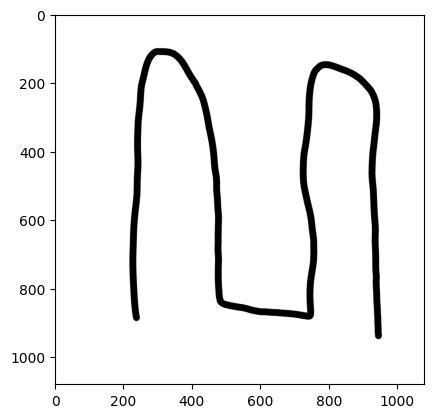

In [73]:
# Menguji Model
test_image_path18 = '../data/databyPhiard_original/prediction/pa10.png'
img = image.load_img(test_image_path18, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path18)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 159ms/step
Predicted class: ra


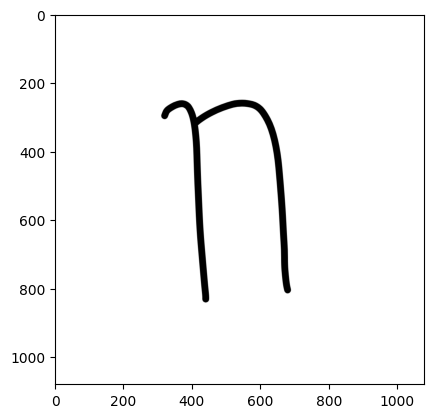

In [74]:
# Menguji Model
test_image_path19 = '../data/databyPhiard_original/prediction/ra164.pred.png'
img = image.load_img(test_image_path19, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path19)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 163ms/step
Predicted class: ra


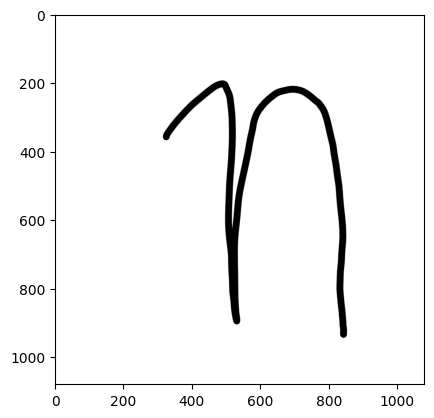

In [75]:
# Menguji Model
test_image_path20 = '../data/databyPhiard_original/prediction/ra3.png'
img = image.load_img(test_image_path20, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path20)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 173ms/step
Predicted class: da


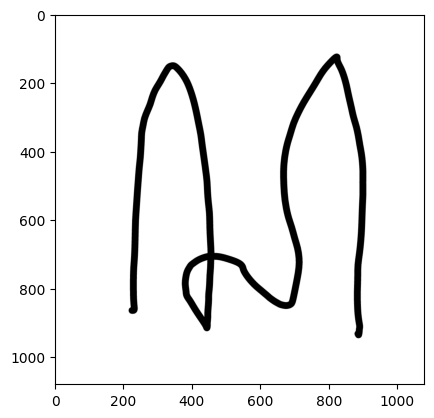

In [76]:
# Menguji Model
test_image_path21 = '../data/databyPhiard_original/prediction/sa7.png'
img = image.load_img(test_image_path21, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path21)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 344ms/step
Predicted class: ta


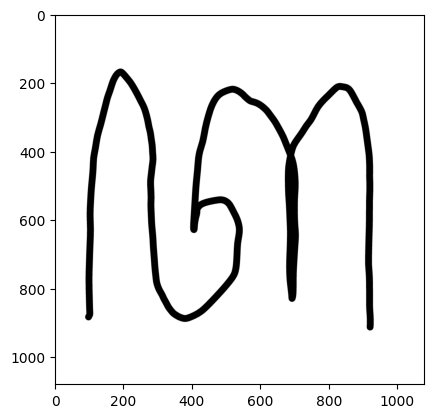

In [77]:
# Menguji Model
test_image_path22 = '../data/databyPhiard_original/prediction/ta6.png'
img = image.load_img(test_image_path22, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path22)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 197ms/step
Predicted class: tha


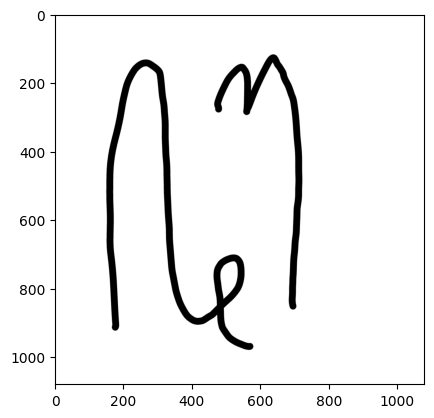

In [78]:
# Menguji Model
test_image_path23 = '../data/databyPhiard_original/prediction/tha18.png'
img = image.load_img(test_image_path23, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path23)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 1s 1s/step
Predicted class: wa


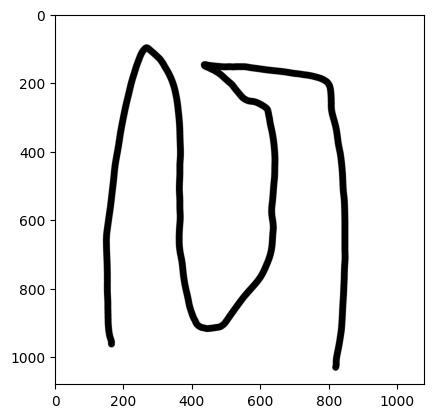

In [79]:
# Menguji Model
test_image_path24 = '../data/databyPhiard_original/prediction/wa8.png'
img = image.load_img(test_image_path24, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path24)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 3s 3s/step
Predicted class: ya


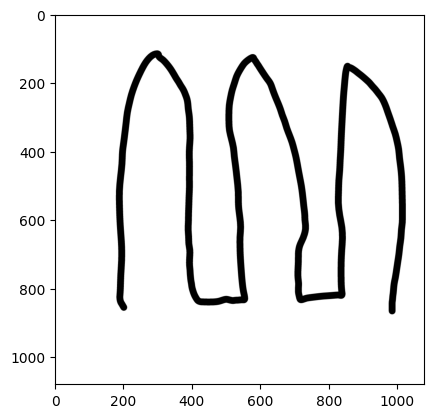

In [80]:
# Menguji Model
test_image_path25 = '../data/databyPhiard_original/prediction/ya13.png'
img = image.load_img(test_image_path25, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path25)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 152ms/step
Predicted class: nya


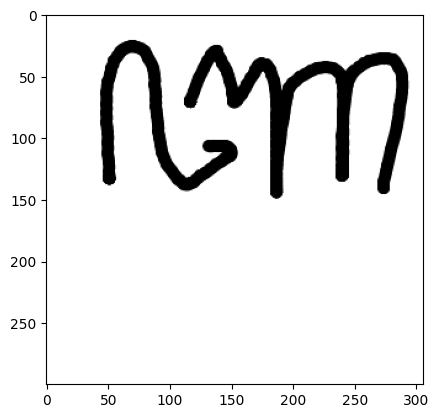

In [82]:
# Menguji Model
test_image_path26 = '../data/databyPhiard_original/prediction/nya_01.png'
img = image.load_img(test_image_path26, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path26)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 229ms/step
Predicted class: sa


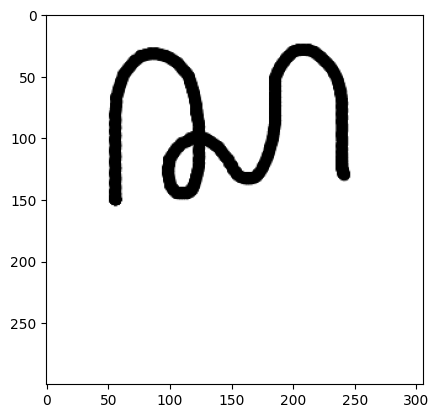

In [83]:
# Menguji Model
test_image_path26 = '../data/databyPhiard_original/prediction/sa_01.png'
img = image.load_img(test_image_path26, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path26)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 179ms/step
Predicted class: ha


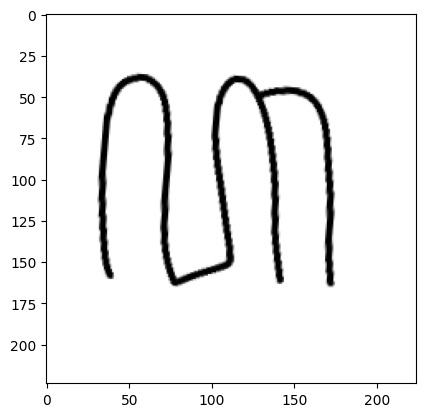

In [85]:
# Menguji Model
test_image_path26 = '../data/databyPhiard_original/prediction/ha201.png'
img = image.load_img(test_image_path26, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

img = imread(test_image_path26)
plt.imshow(img)

# Perform the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)